In [1]:
cd ..

/Users/hyunminhong/Kalman-Heston-Filter


In [2]:
from src.Utility import Utility, MeasurementType
from src.KalmanFilterSV import HestonKalmanFilter
from src.KalmanFilterCorr import HestonKalmanFilterCorr
from src.ParticleFilter import PFHeston
# from src.ContParticleFilter import PFHestonContinuous
from src.Heston import *
from scipy.optimize import minimize
# from filtering.filtering import particle_filter as pf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [3]:
# Set initial conditions and simulation parameters
S0 = 100
V0 = 0.04
params = {
    'mu': 0.05,
    'rho': -0.8,
    'kappa': 11.0,
    'theta': 0.04,
    'xi': 0.9
}
std_asy = np.sqrt(params['theta'] * params['xi']**2 / (2 * params['kappa']))
feller_cond = 2 * params['kappa'] * params['theta'] / params['xi']**2
print(round(feller_cond, 2))
assert feller_cond > 1, "Feller condition is violated!"

Hest = Heston(**params)
time_daily, S_daily, daily_returns, daily_true_V, daily_RV = Hest.path_simulation(
    S0, V0, T_years=10, trading_days=252, intraday_intervals=39, seed=40
)
R_daily = daily_returns.copy()

1.09


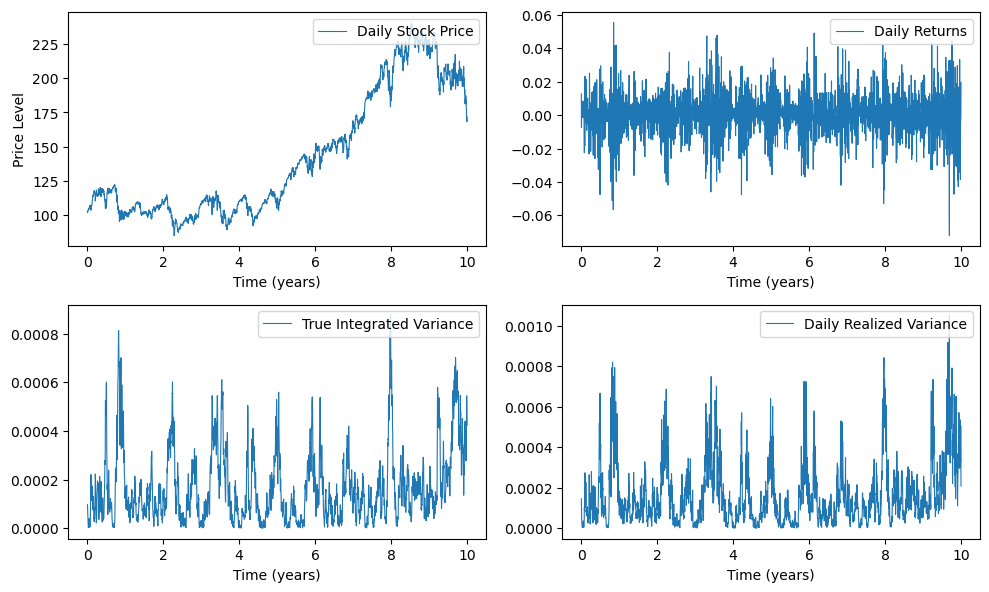

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# Subplot for BOTH measurements
axes[0,0].plot(time_daily, S_daily, label="Daily Stock Price", lw=0.8)
axes[0,0].set_xlabel("Time (years)")
axes[0,0].set_ylabel("Price Level")
axes[0,0].legend(loc="upper right")

# Subplot for RETURNS measurement
axes[0,1].plot(time_daily, daily_returns, label="Daily Returns", lw=0.8)
axes[0,1].set_xlabel("Time (years)")
axes[0,1].legend(loc="upper right")

# Subplot for RV measurement
axes[1,0].plot(time_daily, daily_true_V, label="True Integrated Variance", lw=0.8)
axes[1,0].set_xlabel("Time (years)")
axes[1,0].legend(loc="upper right")

# Subplot for RV measurement
axes[1,1].plot(time_daily, daily_RV, label="Daily Realized Variance", lw=0.8)
axes[1,1].set_xlabel("Time (years)")
axes[1,1].legend(loc="upper right")

plt.tight_layout()
plt.show()

In [5]:
burnin = 252
dt = 1  # Daily

split_index = 6 * 252 

# TRAINING SET 
train_returns = daily_returns[:split_index]
train_RV = daily_RV[:split_index]

# TEST SET 
test_returns = daily_returns[split_index:]
test_RV = daily_RV[split_index:]

### Both

In [ ]:
# Fit the model using training data
hkf_both = HestonKalmanFilter(measurement_type=MeasurementType.BOTH, dt=dt, V0=0.01, P0=0.1)
hkf_both.set_data(returns=train_returns, rv=train_RV)
initial_params_both = np.array([0.001, 0.001, 0.001, 0.001, 0.001]) 
# 1e-02, 1e-04, 8e-04, 4e-04, 3.16325904e-06

fit_results_both = hkf_both.fit(initial_params=initial_params_both, burnin=burnin)
params_opt_both = fit_results_both['params']
print("Optimized parameters (BOTH):", params_opt_both)

train_result_both = hkf_both.filter(params_opt_both)
last_V_train = train_result_both['V_filt'][-1]
last_P_train = train_result_both['P_filt'][-1]

hkf_both_test = HestonKalmanFilter(measurement_type=MeasurementType.BOTH, dt=dt, V0=last_V_train, P0=last_P_train)
V_filt_both_test = hkf_both_test.filter(params=params_opt_both, returns=test_returns, rv=test_RV)['V_filt']

### Both - Corr

In [7]:
hkf_both_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.BOTH, dt=dt, V0=0.01, P0=0.1)
hkf_both_corr.set_data(returns=train_returns, rv=train_RV)
initial_params_both_corr = np.array([0.015, 0.0001, 0.001, 0.001, 0.001, -0.1])
# initial_params_both_corr = np.array([0.1, 0.01, 0.01, 0.001, 0.001, -0.1])

fit_results_both_corr = hkf_both_corr.fit(initial_params=initial_params_both_corr, burnin=burnin)
params_opt_both_corr = fit_results_both_corr['params']
print("Optimized parameters (BOTH):", params_opt_both_corr)

train_result_both_corr = hkf_both_corr.filter(params_opt_both_corr)
last_V_train_corr = train_result_both_corr['V_filt'][-1]
last_P_train_corr = train_result_both_corr['P_filt'][-1]

hkf_both_test_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.BOTH, dt=dt, V0=last_V_train_corr, P0=last_P_train_corr)
test_result_both_corr = hkf_both_test_corr.filter(params=params_opt_both_corr, returns=test_returns, rv=test_RV)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.39940D+04    |proj g|=  1.64858D+05

At iterate    1    f= -1.40013D+04    |proj g|=  1.27071D+05

At iterate    2    f= -1.40200D+04    |proj g|=  1.03144D+05

At iterate    3    f= -1.40489D+04    |proj g|=  8.16712D+04

At iterate    4    f= -1.40604D+04    |proj g|=  3.66647D+04

At iterate    5    f= -1.40680D+04    |proj g|=  2.10781D+04

At iterate    6    f= -1.40709D+04    |proj g|=  5.95679D+03

At iterate    7    f= -1.40728D+04    |proj g|=  2.09901D+02

At iterate    8    f= -1.40737D+04    |proj g|=  2.05203D+02

At iterate    9    f= -1.40742D+04    |proj g|=  1.87259D+02

At iterate   10    f= -1.40742D+04    |proj g|=  1.85404D+02

At iterate   11    f= -1.40742D+04    |proj g|=  1.84994D+02

At iterate   12    f= -1.40742D+04    |proj g|=  5.00241D+02

At iterate   13    f= -1.4

/Users/hyunminhong/anaconda3/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0



QMLE Results for Heston Model:
At iterate   47    f= -1.41375D+04    |proj g|=  1.54929D+04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     47     60     51     0     0   1.549D+04  -1.414D+04
  F =  -14137.520770117659     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

--------------------------------------------------
kappa: 0.043207
theta: 0.000154
xi: 0.002341
mu: -0.000096
sigma: 0.000156
rho: -0.815174
Negative Log-Likelihood: -14137.520770
Convergence: True
--------------------------------------------------
Optimized parameters (BOTH): [ 4.32072027e-02  1.54006289e-04  2.34115622e-03 -9

### Return

In [8]:
# Fit the model using training data
hkf_returns = HestonKalmanFilter(measurement_type=MeasurementType.RETURNS, dt=dt, V0=0.01, P0=0.1)
hkf_returns.set_data(returns=train_returns)
initial_params_returns = np.array([0.001, 0.001, 0.001, 0.001])

fit_results_returns = hkf_returns.fit(initial_params=initial_params_returns, burnin=burnin)
params_opt_returns = fit_results_returns['params']
print("Optimized parameters (RETURNS):", params_opt_returns)

train_result_returns = hkf_returns.filter(params_opt_returns)
last_V_returns = train_result_returns['V_filt'][-1]
last_P_returns = train_result_returns['P_filt'][-1]

hkf_returns_test = HestonKalmanFilter(measurement_type=MeasurementType.RETURNS, dt=dt, V0=last_V_returns, P0=last_P_returns)
V_filt_returns_test = hkf_returns_test.filter(params=params_opt_returns, returns=test_returns)['V_filt']

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.96052D+03    |proj g|=  4.24845D+05

At iterate    1    f= -3.10318D+03    |proj g|=  4.27673D+01

At iterate    2    f= -3.31589D+03    |proj g|=  4.60062D+01

At iterate    3    f= -3.32139D+03    |proj g|=  1.07269D+02

At iterate    4    f= -3.32442D+03    |proj g|=  3.99186D+03

At iterate    5    f= -3.32740D+03    |proj g|=  1.52782D+05

At iterate    6    f= -3.33331D+03    |proj g|=  7.91533D+03

At iterate    7    f= -3.34223D+03    |proj g|=  4.16555D+05

At iterate    8    f= -3.35064D+03    |proj g|=  7.44793D+05

At iterate    9    f= -3.35917D+03    |proj g|=  8.27878D+05

At iterate   10    f= -3.40788D+03    |proj g|=  5.94326D+06
  Positive dir derivative in projection 
  Using the backtracking step 

At iterate   11    f= -3.56536D+03    |proj g|=  1.27236D+06

At iterate   12 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


### Return - Corr

In [9]:
# Fit the model using training data
hkf_returns_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.RETURNS, dt=dt, V0=0.02, P0=0.1)
hkf_returns_corr.set_data(returns=train_returns)
initial_params_returns_corr = np.array([0.002, 0.0001, 0.007, 0.002, 0])

fit_results_returns_corr = hkf_returns_corr.fit(initial_params=initial_params_returns_corr, burnin=burnin)
params_opt_returns_corr = fit_results_returns_corr['params']
print("Optimized parameters (RETURNS):", params_opt_returns_corr)

train_result_returns_corr = hkf_returns_corr.filter(params_opt_returns_corr)
last_V_returns_corr = train_result_returns_corr['V_filt'][-1]
last_P_returns_corr = train_result_returns_corr['P_filt'][-1]

hkf_returns_test_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.RETURNS, dt=dt, V0=last_V_returns_corr, P0=last_P_returns_corr)
test_result_returns_corr = hkf_returns_test_corr.filter(params=params_opt_returns_corr, returns=test_returns)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.46492D+03    |proj g|=  1.93432D+05

At iterate    1    f= -3.71636D+03    |proj g|=  2.93667D+06

At iterate    2    f= -3.73221D+03    |proj g|=  3.31876D+01

At iterate    3    f= -3.75372D+03    |proj g|=  5.65808D+01

At iterate    4    f= -3.76907D+03    |proj g|=  1.04699D+02

At iterate    5    f= -3.76933D+03    |proj g|=  1.00312D+05

At iterate    6    f= -3.76949D+03    |proj g|=  1.15183D+02

At iterate    7    f= -3.76950D+03    |proj g|=  1.15534D+02

At iterate    8    f= -3.76959D+03    |proj g|=  4.15330D+04

At iterate    9    f= -3.76975D+03    |proj g|=  8.53339D+04

At iterate   10    f= -3.77024D+03    |proj g|=  1.71349D+05

At iterate   11    f= -3.77135D+03    |proj g|=  2.89094D+05

At iterate   12    f= -3.77383D+03    |proj g|=  4.22650D+05

At iterate   13    f= -3.7

### RV

In [10]:
hkf_rv = HestonKalmanFilter(measurement_type=MeasurementType.RV, dt=dt, V0=0.01, P0=0.1)
hkf_rv.set_data(rv=train_RV)
initial_params_rv = np.array([0.001, 0.001, 0.001, 0.001])

fit_results_rv = hkf_rv.fit(initial_params=initial_params_rv, burnin=burnin)
params_opt_rv = fit_results_rv['params']
print("Optimized parameters (RV):", params_opt_rv)

train_result_rv = hkf_rv.filter(params_opt_rv)
last_V_rv = train_result_rv['V_filt'][-1]
last_P_rv = train_result_rv['P_filt'][-1]

hkf_rv_test = HestonKalmanFilter(measurement_type=MeasurementType.RV, dt=dt, V0=last_V_rv, P0=last_P_rv)
test_result_rv = hkf_rv_test.filter(params=params_opt_rv, rv=test_RV)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.13735D+03    |proj g|=  4.64956D+06

At iterate    1    f= -8.86044D+03    |proj g|=  8.70385D+01

At iterate    2    f= -9.98759D+03    |proj g|=  1.12145D-02
  Positive dir derivative in projection 
  Using the backtracking step 

At iterate    3    f= -1.01240D+04    |proj g|=  1.03486D-02

At iterate    4    f= -1.05767D+04    |proj g|=  1.58711D+05



 Nonpositive definiteness in Cholesky factorization in formk;
   refresh the lbfgs memory and restart the iteration.



At iterate    5    f= -1.06388D+04    |proj g|=  5.27171D-03

At iterate    6    f= -1.07006D+04    |proj g|=  2.03354D+01

At iterate    7    f= -1.07331D+04    |proj g|=  7.78384D+02

At iterate    8    f= -1.07862D+04    |proj g|=  2.58222D+04

At iterate    9    f= -1.07930D+04    |proj g|=  2.24255D+04

At iterate   10    f= -1.07986D+04    |proj g|=  4.17223D+03

At iterate   11    f= -1.07999D+04    |proj g|=  4.31021D+03

At iterate   12    f= -1.08021D+04    |proj g|=  3.61558D+03

At iterate   13    f= -1.08034D+04    |proj g|=  1.46737D+03

At iterate   14    f= -1.08041D+04    |proj g|=  1.99780D+00

At iterate   15    f= -1.08042D+04    |proj g|=  4.88891D+02

At iterate   16    f= -1.08042D+04    |proj g|=  1.18052D+02

At iterate   17    f= -1.08042D+04    |proj g|=  1.11142D+02

At iterate   18    f= -1.08042D+04    |proj g|=  9.31550D+01

At iterate   19    f= -1.08043D+04    |proj g|=  1.42434D+02

At iterate   20    f= -1.08043D+04    |proj g|=  3.86000D+02

At iter

### PF

In [11]:
pf_heston_train = PFHeston(train_returns, N=5000, dt=1/252, is_log=True)

param_bounds_train = [
    (-0.1, 0.1),    # mu
    (1, 5),        # kappa
    (0.02, 0.03),    # theta
    (0.1, 0.3),    # xi
    (-0.9, 0),        # rho
    V0              # v0
]

_, estimated_param = pf_heston_train.filter(param_bounds_train, predict_obs=False)
param_bounds = list(zip(estimated_param[:,-1] - 1e-3, estimated_param[:,-1] + 1e-3))

resampling since: 1227.5139323203257
resampling since: 1203.920945204883
resampling since: 2387.964569552735
resampling since: 1544.5970226961026
resampling since: 2425.720094124555
resampling since: 3294.097834281484
resampling since: 2753.312022315444
resampling since: 3375.741320453694
resampling since: 3013.587431638799
resampling since: 3017.4370062491134
resampling since: 2197.962812307205
resampling since: 2866.0967221690044
resampling since: 1002.7362140492716
resampling since: 271.04582223868
resampling since: 2846.91466827736
resampling since: 1269.4278670931255
resampling since: 494.1034239135247
resampling since: 3238.7392533847774
resampling since: 860.703674257833
resampling since: 3361.604880454447
resampling since: 1651.8925316050609
resampling since: 2110.2014959681355
resampling since: 2512.325610699165
resampling since: 565.701281140432
resampling since: 2795.4008297333103
resampling since: 1706.2031911587922
resampling since: 1751.9488484537185
resampling since: 305

In [12]:
pf_heston_test = PFHeston(test_returns, N=5000, dt=1/252, is_log=True)

V_pf_train, _ = pf_heston_train.filter([*param_bounds, V0], predict_obs=False)
V_pf_test, _ = pf_heston_test.filter([*param_bounds, V_pf_train[-1]], predict_obs=False)

resampling since: 3250.4521899342917
resampling since: 2821.945196421279
resampling since: 3092.867691290693
resampling since: 3258.694741186671
resampling since: 1126.5436287581053
resampling since: 1372.9378180049534
resampling since: 3341.958382516669
resampling since: 3399.0291082463655
resampling since: 3491.5496717786896
resampling since: 1623.8406668141615
resampling since: 3074.051124080998
resampling since: 2757.6760810843934
resampling since: 3475.7456111251063
resampling since: 2105.7328906727903
resampling since: 3022.3098290267417
resampling since: 2780.6587574801174
resampling since: 3187.4025476883044
resampling since: 3288.453968659584
resampling since: 2781.183919990483
resampling since: 660.4162572228557
resampling since: 3445.0199508606124
resampling since: 3373.612752069638
resampling since: 3464.742143432851
resampling since: 3454.5078088545333
resampling since: 3450.073858168735
resampling since: 2381.8292341429164
resampling since: 3351.041849630026
resampling si

In [13]:
V_pf_train_daily = V_pf_train / 252
V_pf_test_daily = V_pf_test / 252

## Plot

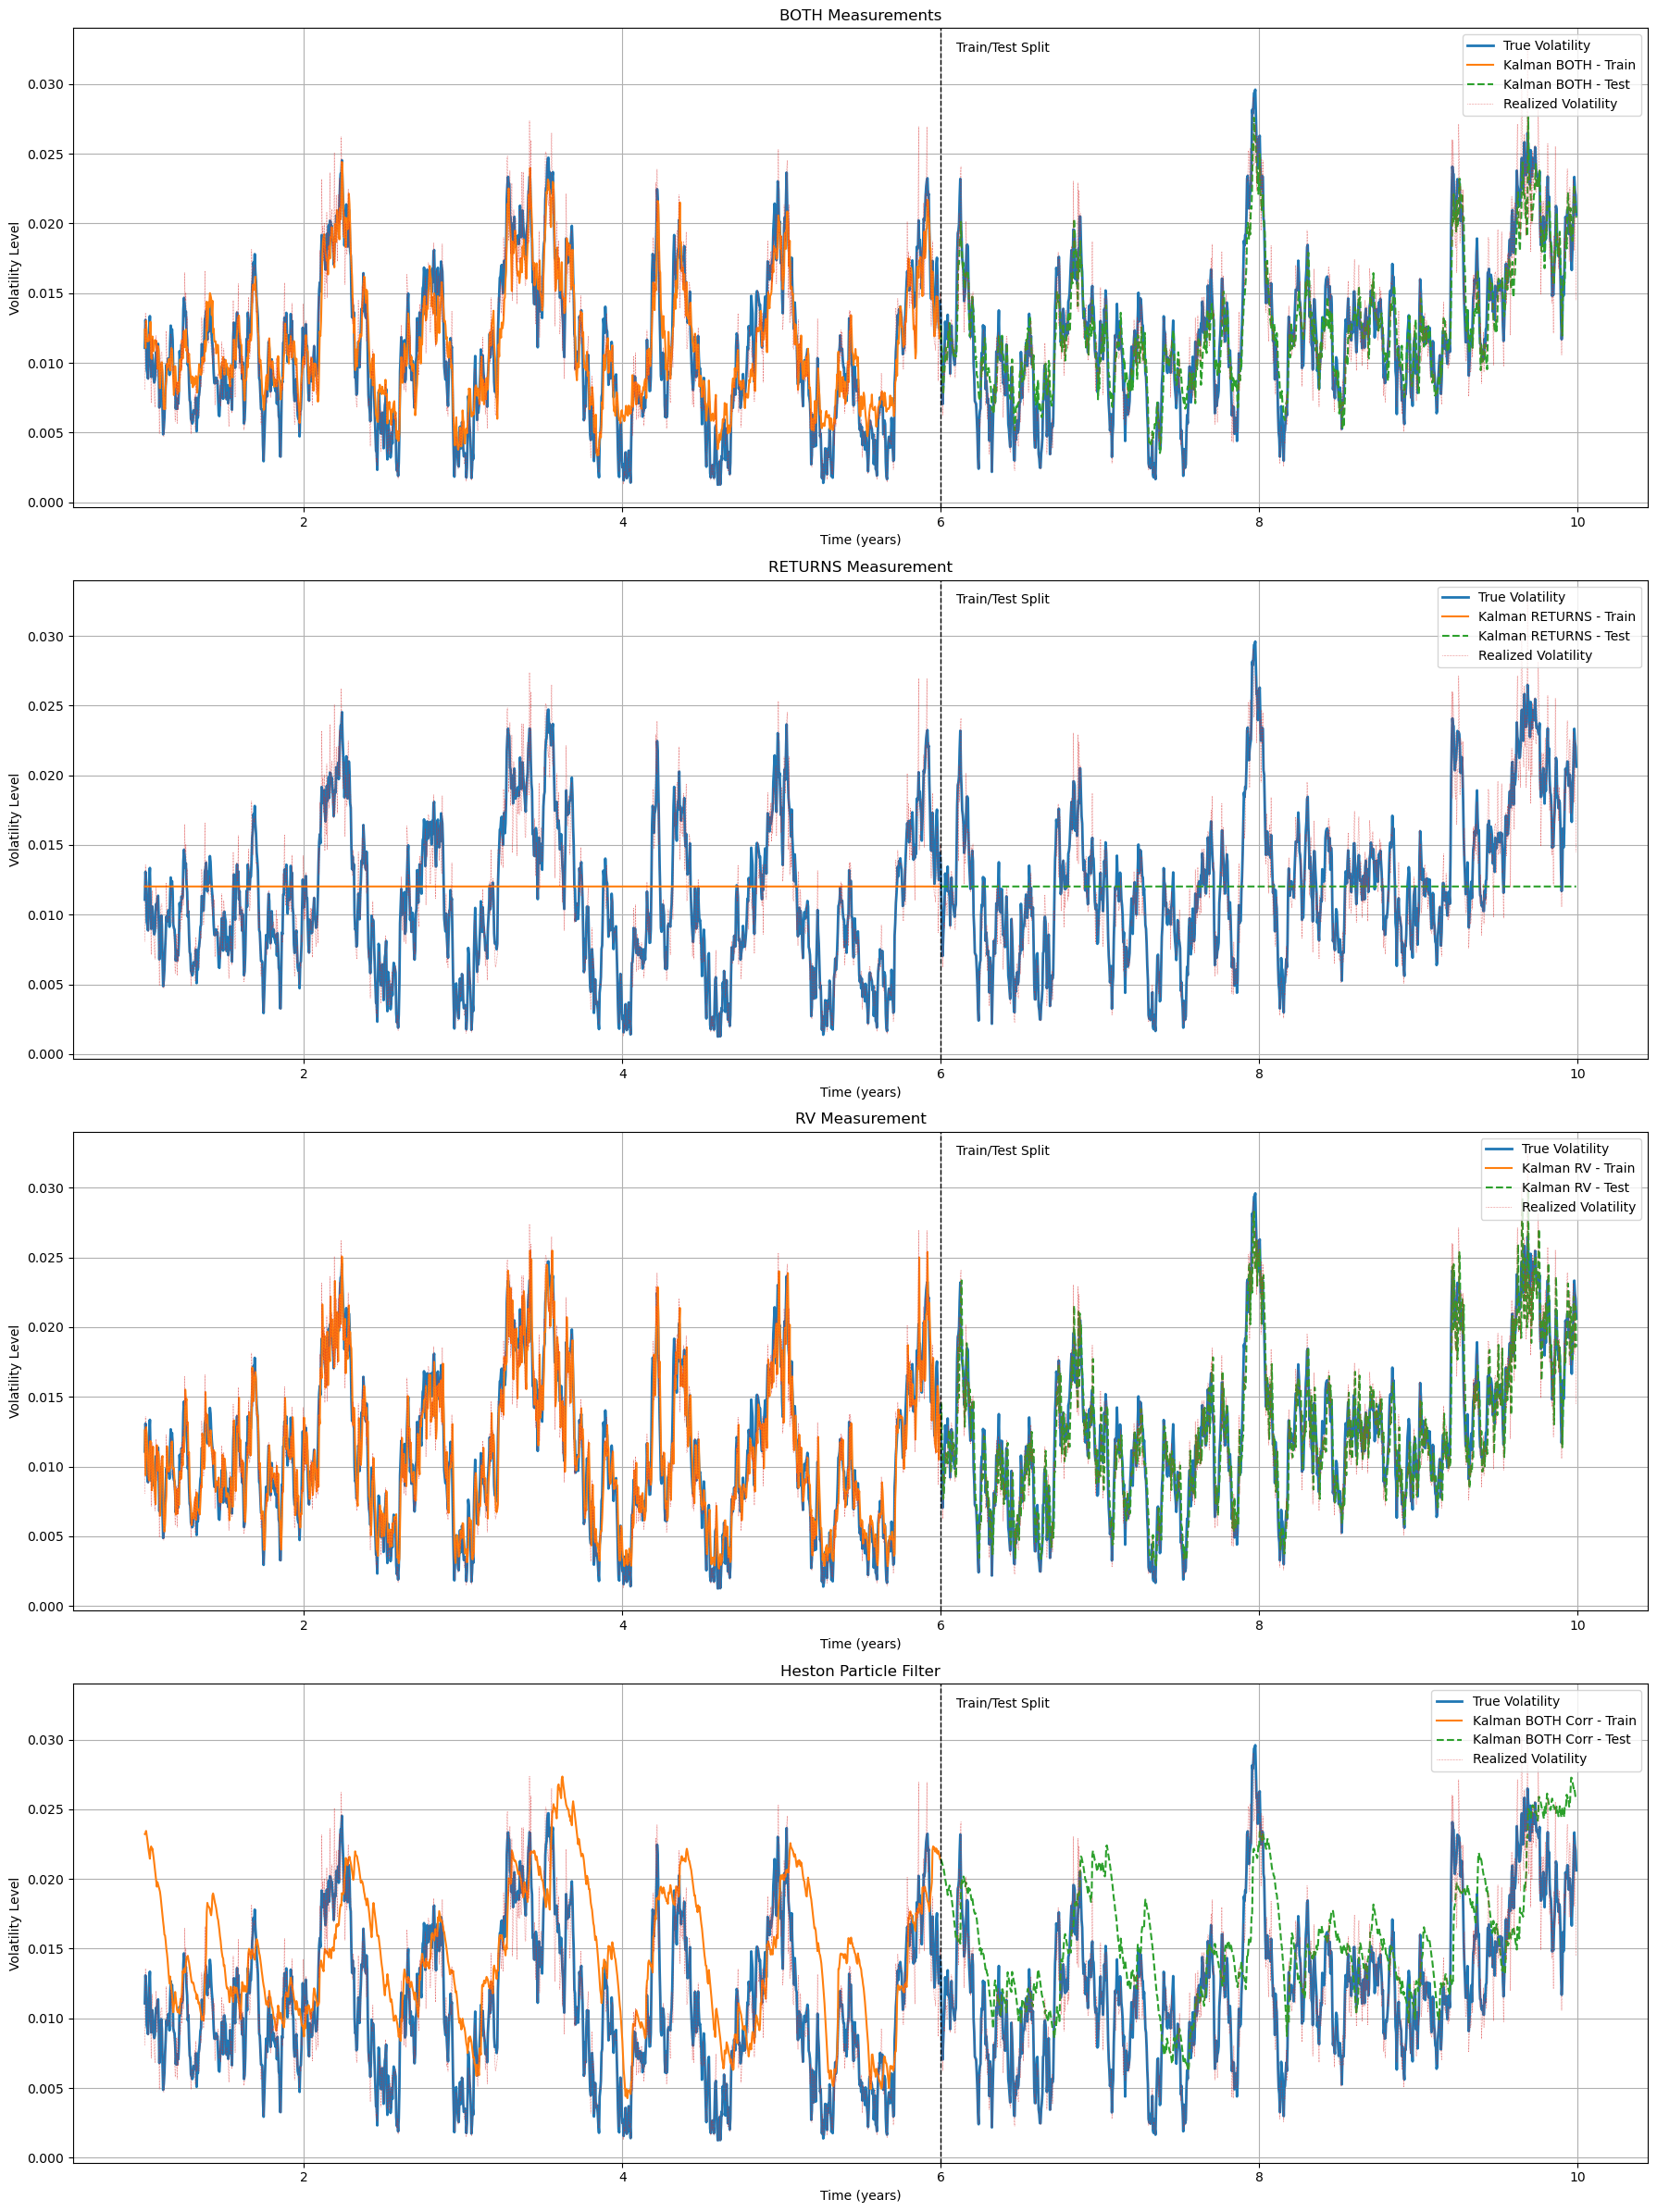

In [14]:
v_item = 'V_pred'

titles_all = ["BOTH Measurements", "RETURNS Measurement", "RV Measurement", "Heston Particle Filter"]
labels_all = ["Kalman BOTH", "Kalman RETURNS", "Kalman RV", "Kalman BOTH Corr", "Kalman RETURNS Corr", "PF Heston"]
train_all = [train_result_both_corr[v_item], train_result_returns_corr[v_item], train_result_rv[v_item], V_pf_train_daily]
test_all = [test_result_both_corr[v_item], test_result_returns_corr[v_item], test_result_rv[v_item], V_pf_test_daily]

Utility.plot_all_filters(
    titles=titles_all,
    labels=labels_all,
    train_filtered_list=train_all,
    test_filtered_list=test_all,
    daily_true_V=daily_true_V,
    daily_RV=daily_RV,
    daily_returns=daily_returns,
    split_index=split_index,
    burnin=252
)
#, save_path=r"C:\Users\688228hh\Kalman-Heston-Filter\output\base.png"

In [ ]:
def qlike_loss(true_var, pred_var):
    y = np.asarray(true_var)
    h = np.asarray(pred_var)
    
    eps = np.finfo(float).eps
    ratio = y / (h + eps)
    return np.mean(ratio - np.log(ratio) - 1)

model_names = ['both_corr', 'returns_corr', 'rv', 'pf']
true_variances   = daily_true_V[split_index:]
true_volatilities = np.sqrt(true_variances)

mae_scores   = {}
rmse_scores  = {}
mape_scores  = {}
qlike_scores = {}

for name, pred_var in zip(model_names, test_all):
    pred_vol = np.sqrt(pred_var)
    
    mae_scores[name]   = mean_absolute_error(true_volatilities, pred_vol)
    rmse_scores[name]  = np.sqrt(mean_squared_error(true_volatilities, pred_vol))
    mape_scores[name]  = mean_absolute_percentage_error(true_volatilities, pred_vol) * 100
    qlike_scores[name] = qlike_loss(true_variances, pred_var)

print("Results including QLIKE:")
for name in model_names:
    print(f"{name:12s} MAE: {mae_scores[name]:.6f}, "
          f"RMSE: {rmse_scores[name]:.6f}, "
          f"MAPE: {mape_scores[name]:.3f}%, "
          f"QLIKE: {qlike_scores[name]:.6f}")


Results including QLIKE:
both_corr    MAE: 0.001541, RMSE: 0.001938, MAPE: 17.481%, QLIKE: 0.082347
returns_corr MAE: 0.004068, RMSE: 0.005331, MAPE: 44.464%, QLIKE: 0.399702
rv           MAE: 0.001503, RMSE: 0.001892, MAPE: 14.595%, QLIKE: 0.069946
pf           MAE: 0.004421, RMSE: 0.005522, MAPE: 53.503%, QLIKE: 0.309746


In [ ]:
data = {}

data['both_corr'] = dict(zip(
    ['kappa', 'theta', 'xi', 'mu', 'sigma', 'rho'],
    params_opt_both_corr
))

data['returns_corr'] = dict(zip(
    ['kappa', 'theta', 'xi', 'mu', 'rho'],
    params_opt_returns_corr
))
data['returns_corr']['sigma'] = np.nan

data['rv'] = dict(zip(
    ['kappa', 'theta', 'xi', 'sigma'],
    params_opt_rv
))
data['rv']['mu']  = np.nan
data['rv']['rho'] = np.nan

pf_vals = estimated_param[:, -1]
data['pf'] = {
    'kappa': pf_vals[1],
    'theta': pf_vals[2],
    'xi':    pf_vals[3],
    'mu':    pf_vals[0],
    'rho':   pf_vals[4],
    'sigma': np.nan
}

cols = ['kappa', 'theta', 'xi', 'mu', 'sigma', 'rho']
df_params = pd.DataFrame.from_dict(data, orient='index')[cols]

df_params.T

,both_corr,returns_corr,rv,pf
kappa,0.043207,1.007260,0.032995,2.087028
theta,0.000154,0.000145,0.000136,0.028064
xi,0.002341,0.022835,0.003804,0.268707
mu,-0.000096,0.000351,NaN,0.075234
sigma,0.000156,NaN,0.002249,NaN
rho,-0.815174,-0.000024,NaN,-0.005973


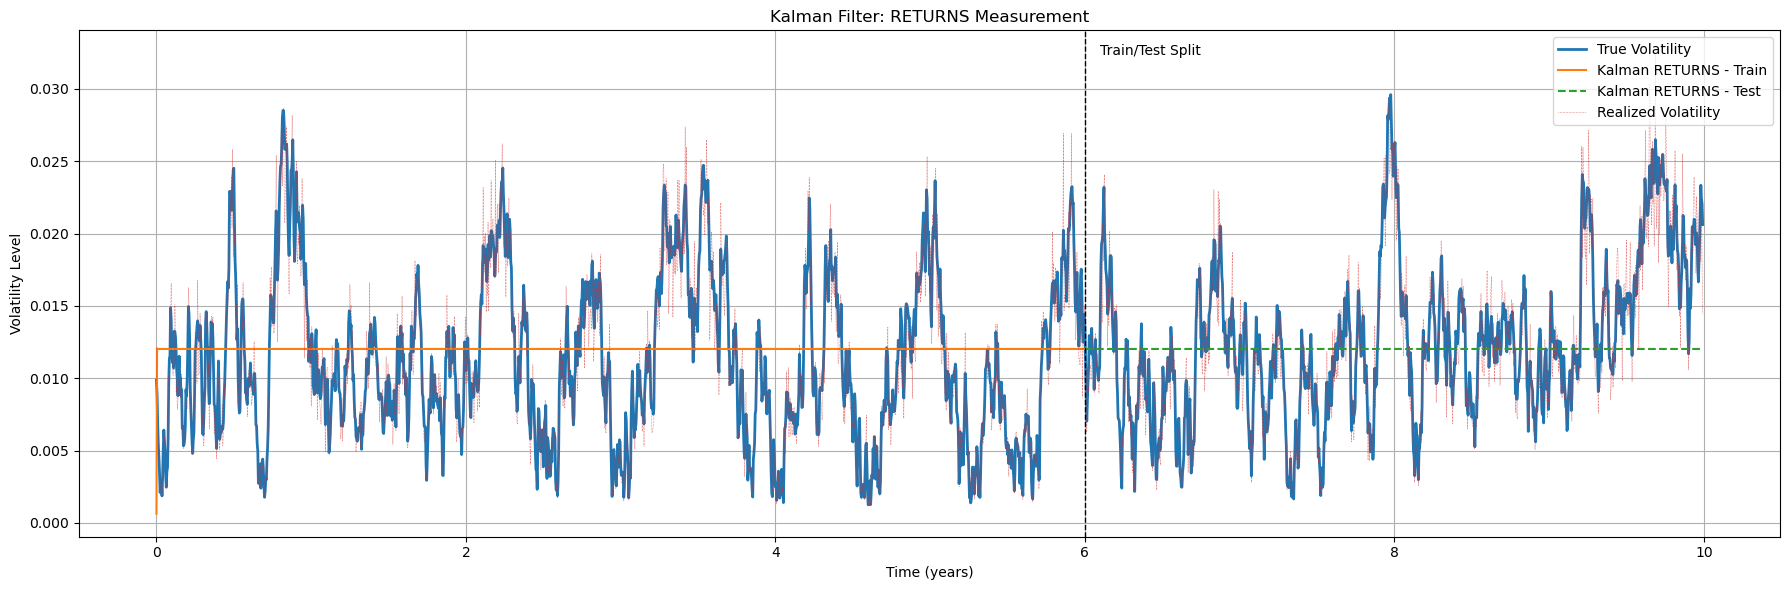

In-Sample RMSE (RETURNS Measurement): 0.005636
Out-of-Sample RMSE (RETURNS Measurement): 0.005331


(0.005635838898271598, 0.0053314594940228055)

In [35]:
Utility.plot_filter_result(
    plot_index=1,
    titles=titles_all,
    labels=labels_all,
    train_filtered_list=train_all,
    test_filtered_list=test_all,
    daily_true_V=daily_true_V,
    daily_RV=daily_RV,
    daily_returns=daily_returns,
    split_index=split_index,
    burnin=0
)